# Repairing artifacts with ICA using ICLabel from EEGLAB

This tutorial covers the basics of independent components analysis (ICA) and shows how ICA can be used for artifact repair; an extended example illustrates repair of ocular and heartbeat artifacts. For conceptual background on ICA, see this scikit-learn tutorial.

We begin as always by importing the necessary Python modules and loading some example data. Because ICA can be computationally intense, we’ll also crop the data to 60 seconds; and to save ourselves from repeatedly typing `mne.preprocessing` we’ll directly import a few functions and classes from that submodule:

In [1]:
import os
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)
# Here we'll crop to 60 seconds and drop gradiometer channels for speed
raw.crop(tmax=60.).pick_types(meg='mag', eeg=True, stim=True, eog=True)
raw.load_data()

Opening raw data file /Users/jacobfeitelberg/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 9009  =      0.000 ...    59.999 secs...


<Raw | sample_audvis_filt-0-40_raw.fif, 171 x 9010 (60.0 s), ~14.8 MB, data loaded>

# Example: EOG and ECG artifact repair

## Visualizing the artifacts

Let’s begin by visualizing the artifacts that we want to repair. In this dataset they are big enough to see easily in the raw data:

Using matplotlib as 2D backend.


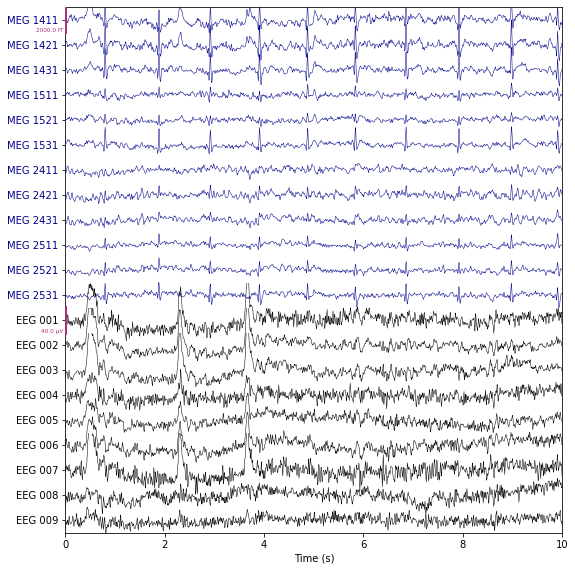

In [2]:
# pick some channels that clearly show heartbeats and blinks
regexp = r'(MEG [12][45][123]1|EEG 00.)'
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)
raw.plot(order=artifact_picks, n_channels=len(artifact_picks),
         show_scrollbars=False)
pass

We can get a summary of how the ocular artifact manifests across each channel type using create_eog_epochs like we did in the Overview of artifact detection tutorial:

Using EOG channel: EOG 061
EOG channel index for this subject is: [170]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1502 samples (10.003 sec)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Loading data for 10 events and 151 original time points ...
0 bad epochs dropped
Applying baseli

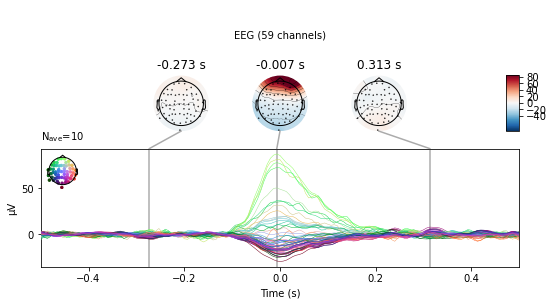

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


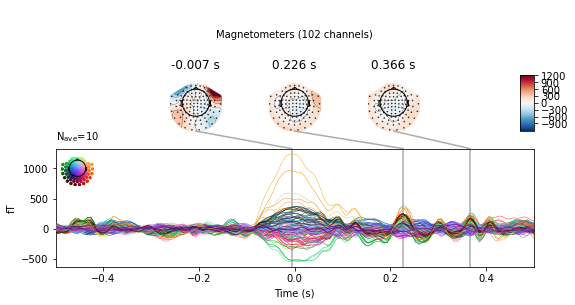

In [3]:
eog_evoked = create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()
pass

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1502 samples (10.003 sec)

Number of ECG events detected : 59 (average pulse 58 / min.)
Not setting metadata
Not setting metadata
59 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Loading data for 59 events and 151 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
SSP projectors applied...
Removing projector <Projection | 

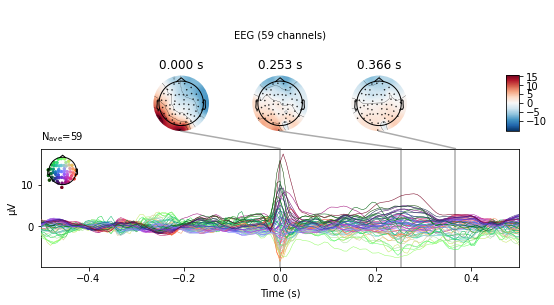

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


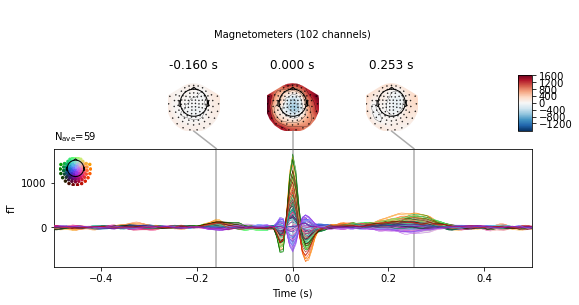

In [4]:
ecg_evoked = create_ecg_epochs(raw).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()
pass

## Filtering to remove slow drifts¶

Before we run the ICA, an important step is filtering the data to remove low-frequency drifts, which can negatively affect the quality of the ICA fit. The slow drifts are problematic because they reduce the independence of the assumed-to-be-independent sources (e.g., during a slow upward drift, the neural, heartbeat, blink, and other muscular sources will all tend to have higher values), making it harder for the algorithm to find an accurate solution. A high-pass filter with 1 Hz cutoff frequency is recommended. However, because filtering is a linear operation, the ICA solution found from the filtered signal can be applied to the unfiltered signal, so we’ll keep a copy of the unfiltered Raw object around so we can apply the ICA solution to it later.

In [5]:
filt_raw = raw.copy().filter(l_freq=1., h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 sec)



## Fitting and plotting the ICA solution

Now we’re ready to set up and fit the ICA. Since we know (from observing our raw data) that the EOG and ECG artifacts are fairly strong, we would expect those artifacts to be captured in the first few dimensions of the PCA decomposition that happens before the ICA. Therefore, we probably don’t need a huge number of components to do a good job of isolating our artifacts (though it is usually preferable to include more components for a more accurate solution). As a first guess, we’ll run ICA with `n_components=15` (use only the first 15 PCA components to compute the ICA decomposition) — a very small number given that our data has over 300 channels, but with the advantage that it will run quickly and we will able to tell easily whether it worked or not (because we already know what the EOG / ECG artifacts should look like).

ICA fitting is not deterministic (e.g., the components may get a sign flip on different runs, or may not always be returned in the same order), so we’ll also specify a random seed so that we get identical results each time this tutorial is built by our web servers.

In [6]:
ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 161 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


Method,fastica
Fit,22 iterations on raw data (9010 samples)
ICA components,15
Explained variance,94.3 %
Available PCA components,161
Channel types,"mag, eeg"
ICA components marked for exclusion,—


Some optional parameters that we could have passed to the `fit` method include `decim` (to use only every Nth sample in computing the ICs, which can yield a considerable speed-up) and `reject` (for providing a rejection dictionary for maximum acceptable peak-to-peak amplitudes for each channel type, just like we used when creating epoched data in the Overview of MEG/EEG analysis with MNE-Python tutorial).

Now we can examine the ICs to see what they captured. `plot_sources` will show the time series of the ICs. Note that in our call to `plot_sources` we can use the original, unfiltered `Raw` object:

Creating RawArray with float64 data, n_channels=16, n_times=9010
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.


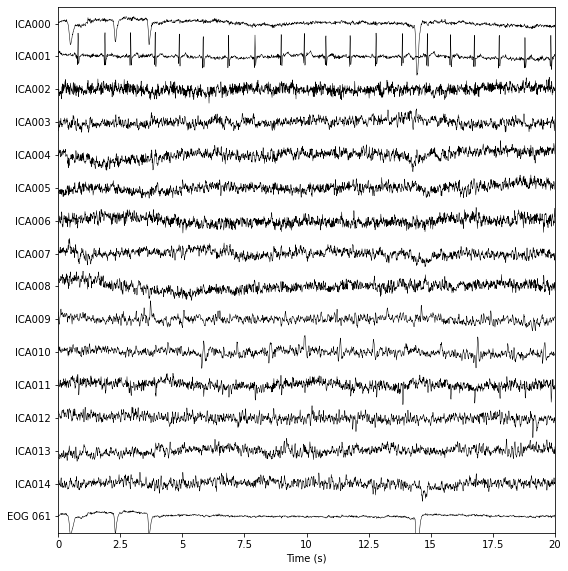

In [7]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)
pass

Here we can pretty clearly see that the first component (`ICA000`) captures the EOG signal quite well, and the second component (`ICA001`) looks a lot like a heartbeat (for more info on visually identifying Independent Components, this EEGLAB tutorial is a good resource). Now, we are ready to create the features for ICLabel.

In [9]:
import numpy as np
from ICLabel import run_iclabel, mne_to_eeglab_locs

icaact = ica.get_sources(raw).get_data()
icaact = np.expand_dims(icaact, 0)
icaact = np.transpose(icaact, [1,2,0])

icaweights = ica.unmixing_matrix_

icawinv = np.linalg.pinv(icaweights @ ica.get_components().T)

srate = int(raw.info['hpi_meas'][0]['sfreq'])
pnts = icaact.shape[1]
trials = 1

rd, th = mne_to_eeglab_locs(raw)

In [23]:
from ICLabel import run_iclabel
from eeg_features import eeg_features

features = eeg_features(icaact = icaact, 
                        trials = trials, 
                        srate = srate, 
                        pnts=pnts, 
                        subset = None,
                        icaweights = icaweights,
                        icawinv = icawinv,
                        th = th,
                        rd = rd)

topo = features[0].astype(np.float32)
psds = features[1].astype(np.float32)
autocorr = features[2].astype(np.float32)

labels = run_iclabel(topo, psds, autocorr)

In [34]:
# Print out
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

print('  Brain ','Muscle','Eye   ','Heart ','Line  ','Noise ','Other')
print(labels)

  Brain  Muscle Eye    Heart  Line   Noise  Other
[[0.03   0.0051 0.0035 0.0005 0.0044 0.0222 0.9344]
 [0.0778 0.1525 0.0014 0.0101 0.1238 0.0439 0.5905]
 [0.0181 0.0098 0.006  0.     0.0231 0.0048 0.9382]
 [0.0331 0.0062 0.0015 0.     0.0214 0.0007 0.9371]
 [0.0196 0.0414 0.0022 0.0017 0.1666 0.0566 0.7118]
 [0.0256 0.0011 0.0004 0.0013 0.0044 0.0024 0.9648]
 [0.0301 0.0012 0.0014 0.0008 0.0142 0.0155 0.9366]
 [0.0599 0.0372 0.0007 0.004  0.0112 0.0234 0.8636]
 [0.0114 0.0013 0.0001 0.0001 0.033  0.0037 0.9504]
 [0.0073 0.0059 0.0004 0.1903 0.0006 0.2247 0.5709]
 [0.137  0.0004 0.006  0.     0.003  0.0481 0.8055]
 [0.0179 0.0155 0.0194 0.0008 0.0257 0.0067 0.914 ]
 [0.0496 0.0026 0.0015 0.0002 0.0124 0.0054 0.9283]
 [0.0048 0.037  0.0042 0.1358 0.0001 0.02   0.798 ]
 [0.0476 0.0208 0.0003 0.0045 0.0102 0.0052 0.9114]]


In [ ]:
labels

In [13]:
from eeg_features import eeg_autocorr_fftw, eeg_features, eeg_rpsd, eeg_topoplot

In [10]:
autocorr = eeg_autocorr_fftw(icaact, trials, srate, pnts=pnts)


In [12]:
def mne_to_eeglab_locs(raw):
    def sph2topo(theta,phi):
        az = phi
        horiz = theta
        angle  = -1*horiz
        radius = (np.pi/2 - az)/np.pi
        return angle,radius

    def cart2sph(x,y,z):
        azimuth = np.arctan2(y,x)
        elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
        r = np.sqrt(x**2 + y**2 + z**2)
        # theta,phi,r
        return azimuth, elevation, r
    
    locs = raw._get_channel_positions()

    #%% Obtain carthesian coordinates
    X = locs[:,1]
    Y = -1*locs[:,0] # be mindful of the nose orientation in eeglab and mne 
    # see https://github.com/mne-tools/mne-python/blob/24377ad3200b6099ed47576e9cf8b27578d571ef/mne/io/eeglab/eeglab.py#L105
    Z = locs[:,2]

    #%% Obtain Spherical Coordinates 
    sph = np.array([cart2sph(X[i],Y[i],Z[i]) for i in range(len(X))])
    theta = sph[:,0]
    phi = sph[:,1]

    #%% Obtain Polar coordinates (as in eeglab)
    topo = np.array([sph2topo(theta[i],phi[i]) for i in range(len(theta))])
    Rd = topo[:,1]
    Th = topo[:,0]
    
    return Rd.reshape([1,-1]), np.degrees(Th).reshape([1,-1])

In [7]:
Rd, Th = mne_to_eeglab_locs(epochs)

In [30]:
import scipy.io as sio

topoplot_data = sio.loadmat('test_data/topoplot_data.mat')

# Inputs
icawinv = topoplot_data['icawinv']
rd = topoplot_data['Rd']
th = topoplot_data['Th']
plotchans = topoplot_data['plotchans']

In [98]:
i = 10
plotchans = np.squeeze(np.argwhere(~np.isnan(np.squeeze(Th))))
topo = eeg_topoplot(icawinv = icawinv[:, i:i+1], Th=Th, Rd=Rd, plotchans = plotchans)

In [8]:
trials

80

In [9]:
features = eeg_features(icaact = icaact, 
                        trials = trials, 
                        srate = srate, 
                        pnts=pnts, 
                        subset = None,
                        icaweights = icaweights,
                        icawinv = icawinv,
                        Th = Th,
                        Rd = Rd)

In [17]:
topo = features[0].astype(np.float32)
psds = features[1].astype(np.float32)
autocorr = features[2].astype(np.float32)

/var/folders/94/8sjp_yhj77xf3pmh4s5v0ttm0000gn/T/ipykernel_85198/3065674191.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  autocorr = features[2].astype(np.float32)


In [11]:
from ICLabel import run_iclabel

In [18]:
print(topo.shape, psds.shape, autocorr.shape)
print(topo.dtype, psds.dtype, autocorr.dtype)

(32, 32, 1, 30) (1, 100, 1, 30) (1, 100, 1, 30)
float32 float32 float32


In [20]:
labels = run_iclabel(topo, psds, autocorr)

In [22]:
# Print out
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [23]:
print(labels)

[[0.5302 0.001  0.032  0.0015 0.0273 0.0551 0.353 ]
 [0.425  0.0009 0.0089 0.0006 0.0691 0.0273 0.4683]
 [0.2554 0.0001 0.0077 0.003  0.2128 0.0096 0.5113]
 [0.3174 0.002  0.0597 0.0033 0.2016 0.0884 0.3275]
 [0.1188 0.0014 0.0022 0.0071 0.5116 0.0388 0.32  ]
 [0.1053 0.0006 0.0016 0.0015 0.4571 0.0065 0.4273]
 [0.2314 0.0004 0.1386 0.0152 0.0548 0.043  0.5165]
 [0.0536 0.0033 0.0844 0.0277 0.5242 0.0086 0.2982]
 [0.341  0.0001 0.023  0.0053 0.089  0.0181 0.5236]
 [0.1197 0.0002 0.0768 0.0038 0.1132 0.0152 0.6712]
 [0.6001 0.001  0.0084 0.0045 0.0487 0.1488 0.1885]
 [0.3207 0.0006 0.0004 0.002  0.3334 0.0035 0.3395]
 [0.049  0.0003 0.0021 0.0019 0.2206 0.0037 0.7224]
 [0.1791 0.0007 0.021  0.0009 0.06   0.0099 0.7284]
 [0.2751 0.0003 0.0142 0.0183 0.2983 0.0146 0.3792]
 [0.5767 0.0001 0.0021 0.0004 0.4122 0.0006 0.008 ]
 [0.2947 0.0004 0.0034 0.0068 0.2957 0.0007 0.3984]
 [0.7006 0.0011 0.007  0.0021 0.1637 0.0034 0.1222]
 [0.8109 0.001  0.004  0.0011 0.04   0.007  0.1361]
 [0.4687 0.0